In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incomplete2OG2VP/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimnesion 64x64

In [ ]:
sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 64, 64, 20)
0.0 1.0


In [ ]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [ ]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,64,64,seqlen-1))
      batch_y = np.zeros((batchsize,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #print("minibatch: ",minibatch.shape)
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,:,:,random_start:random_end]
          batch_y[i] = minibatch[i,:,:,random_end:random_end+1]
          #if i == 1:
            #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
      yield(batch_x,batch_y)
prova = image_generator(testset)
sample_x, sample_y = next(prova)

In [ ]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(8, 8 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        if i < 3:
            plt.title('Frame ' + str(i))
        elif i == 3:
            plt.title('GT')
        elif i == 4:
            plt.title('Prediction')
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

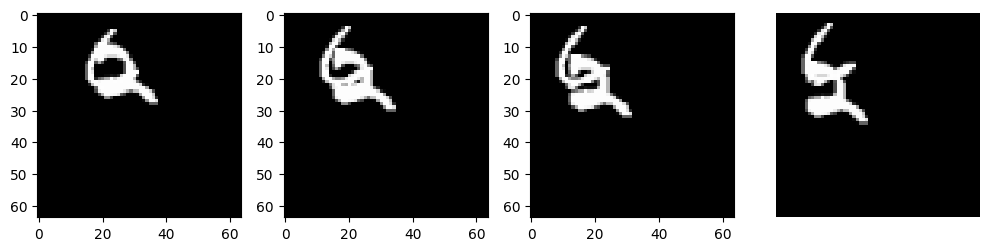

In [ ]:
sample_x, sample_y = next(prova)
all = [sample_x[0,:,:,i] for i in range(3)]+[sample_y[0,:,:,0]]
show_list(all)

In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

In [ ]:
sample_x, sample_y = next(train_gen)
print("sample_x", sample_x.shape)
print("sample_y",sample_y.shape)

sample_x (16, 64, 64, 3)
sample_y (16, 64, 64, 1)


# The Model

This model is based on SimVP network (https://arxiv.org/abs/2211.12509)

This model is called Simple Video Prediction because it doesn't use anything other than CNN to predict the next frames

Since the original network is based on a sequence-to-sequence architecture, we need to transform it into a sequence-to-one architecture. To do that we can use the frames as channels so the input image of the net will have shape (width, height, channels)

## Overview of the Model
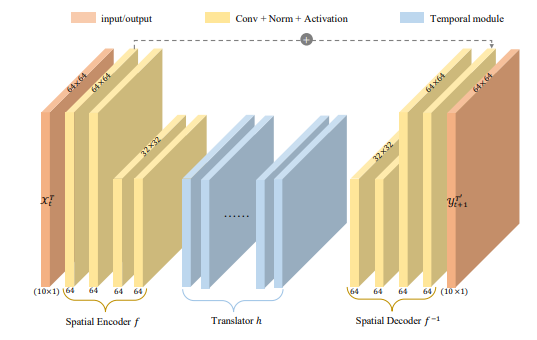



The spatial encoder is used to expand the number of channels from 3 to 192(64*3) and downsample the size of the image from (64,64) to (32,32) which is the latent space. The spatial decoder is used to upsample from the latent space to the original size and reduces the number of channels from 192 to 1

The translator is composed of 3 gated spatiotemporal attention (gSTA) module, each of which is composed of:

*   depth-wise convolution that captures local receptive
fields within a single channel
*  a depth-wise dilation convolution that builds connections between distant receptive fields
* a 1 × 1 convolution that performs channel-wise interactions

The output of the last convolution is split into 2 part g and z

A sigmoid is applied on g as an attention gate and the result is multiplied with z


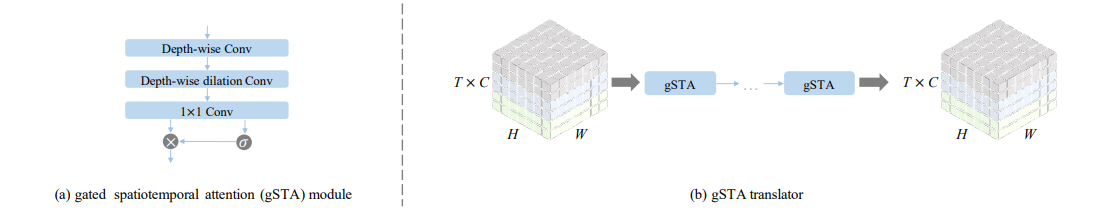

Adding more than 3 gSTA modules doesn't seem to decrease MSE at least within 90 epochs


To preserve the spatial feature there is also a residual connection from the encoder to the decoder


In [ ]:
def createModel(input_shape):
  num_channels = 64
  num_layers = 3  #number of gSTA modules
  W,H,F = input_shape  #width, height, frames
  inp = layers.Input(shape= (W,H,F))

  #Spatial encoder
  #first couple of CNN -> Normalization -> Activation
  cn_layer11 = layers.Conv2D(num_channels*F, 3, strides=(1, 1), padding='same')(inp)
  cn_layer11 = layers.BatchNormalization()(cn_layer11)
  cn_layer11 = layers.LeakyReLU(alpha=0.2)(cn_layer11) #changing the name to reuse this first layer at the end

  cn_layer12 = layers.Conv2D(num_channels*F, 3, strides=(1, 1), padding='same')(cn_layer11)
  cn_layer12 = layers.BatchNormalization()(cn_layer12)
  cn_layer12 = layers.LeakyReLU(alpha=0.2)(cn_layer12)

  #downsample
  cn_layer2 = layers.MaxPool2D(padding='same')(cn_layer12)
  cn_layer2 = layers.BatchNormalization()(cn_layer2)

  #second couple of CNN -> Normalization -> Activation
  cn_layer2 = layers.Conv2D(num_channels*F, 3, strides=(1,1), padding='same')(cn_layer2)
  cn_layer2 = layers.BatchNormalization()(cn_layer2)
  cn_layer2 = layers.LeakyReLU(alpha=0.2)(cn_layer2)
  cn_layer2 = layers.Conv2D(num_channels*F, 3, strides=(1,1), padding='same')(cn_layer2)
  cn_layer2 = layers.BatchNormalization()(cn_layer2)
  cn_layer2 = layers.LeakyReLU(alpha=0.2)(cn_layer2)

  #Translator
  #attention based gSTA
  for layer in range(num_layers):
    if layer == 0:
      placeholder = cn_layer2
    gSTA = layers.DepthwiseConv2D(3, strides=(1,1), padding='same')(placeholder)
    gSTA = layers.DepthwiseConv2D(3, strides=(1,1), padding='same',dilation_rate=(1, 1))(gSTA)
    gSTA = layers.Conv2D(num_channels*F, 1, strides=(1,1), padding='same')(gSTA)
    split_layer = keras.layers.Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))(gSTA)
    g = split_layer[0]
    g = keras.activations.sigmoid(g)
    z = split_layer[1]
    gSTA = layers.Multiply()([g,z])
    placeholder = gSTA

  #Spatial encoder
  #first couple of CNN -> Normalization -> Activation
  decoder_layer1 = layers.Conv2D(num_channels*F, 3, strides=(1, 1), padding='same')(gSTA)
  decoder_layer1 = layers.BatchNormalization()(decoder_layer1)
  decoder_layer1 = layers.LeakyReLU(alpha=0.2)(decoder_layer1)
  decoder_layer1 = layers.Conv2D(num_channels*F, 3, strides=(1, 1), padding='same')(decoder_layer1)
  decoder_layer1 = layers.BatchNormalization()(decoder_layer1)
  decoder_layer1 = layers.LeakyReLU(alpha=0.2)(decoder_layer1)

  #upsample
  decoder_layer1 = layers.Conv2DTranspose(num_channels*F, 3, 2, padding='same')(decoder_layer1)
  decoder_layer1 = layers.BatchNormalization()(decoder_layer1)

  #second couple of CNN -> Normalization -> Activation
  decoder_layer2 = layers.Conv2D(num_channels*F, 3, strides=(1, 1), padding='same')(decoder_layer1)
  decoder_layer2 = layers.BatchNormalization()(decoder_layer2)
  decoder_layer2 = layers.LeakyReLU(alpha=0.2)(decoder_layer2)

  decoder_layer2 = layers.Add()([decoder_layer2,cn_layer11])
  decoder_layer2 = layers.Conv2D(1, 3, strides=(1, 1), padding='same')(decoder_layer2)
  decoder_layer2 = layers.BatchNormalization()(decoder_layer2)
  decoder_layer2 = layers.LeakyReLU(alpha=0.2)(decoder_layer2)
  model = keras.models.Model(inp, decoder_layer2)
  model.summary()
  return model
model = createModel((64,64,3))
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), optimizer=keras.optimizers.Adam()
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 192)  5376        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 192)  768        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 192)  0           ['batch_normalization[0][0]']

# Training
The model is trained using 90 epochs

In [ ]:
epochs = 80

history = model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch= len(trainset) // 16,
    validation_data=(val_gen),
    validation_steps=len(valset) // 16,
)

Epoch 1/80
500/500 [==============================] - 65s 89ms/step - loss: 0.0577 - val_loss: 0.0296
Epoch 2/80
500/500 [==============================] - 45s 90ms/step - loss: 0.0294 - val_loss: 0.0240
Epoch 3/80
500/500 [==============================] - 45s 91ms/step - loss: 0.0179 - val_loss: 0.0242
Epoch 4/80
500/500 [==============================] - 46s 93ms/step - loss: 0.0147 - val_loss: 0.0165
Epoch 5/80
500/500 [==============================] - 46s 92ms/step - loss: 0.0134 - val_loss: 0.0150
Epoch 6/80
500/500 [==============================] - 47s 95ms/step - loss: 0.0128 - val_loss: 0.0145
Epoch 7/80
500/500 [==============================] - 47s 93ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 8/80
500/500 [==============================] - 46s 93ms/step - loss: 0.0119 - val_loss: 0.0125
Epoch 9/80
500/500 [==============================] - 47s 94ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 10/80
500/500 [==============================] - 47s 93ms/step - loss: 0.011

In [ ]:
#model.save('MattiaMaranzana.keras')
#model = keras.models.load_model('MattiaMaranzana.keras')

Now we can compute the MSE on the test set

In [ ]:
mse = model.evaluate(test_gen,steps=1000)

1000/1000 [==============================] - 31s 31ms/step - loss: 0.0068


# Visualize some results

Now that we have a trained model we can visualize some images


1/1 [==============================] - 0s 21ms/step


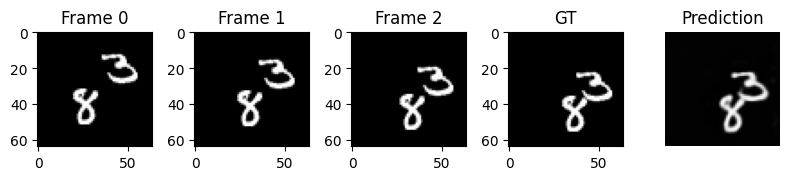

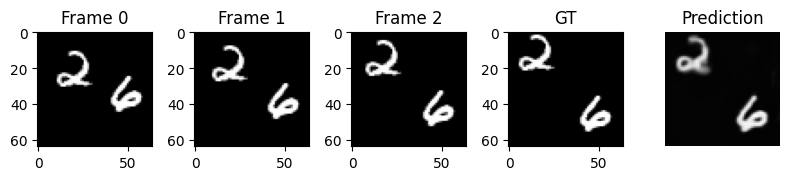

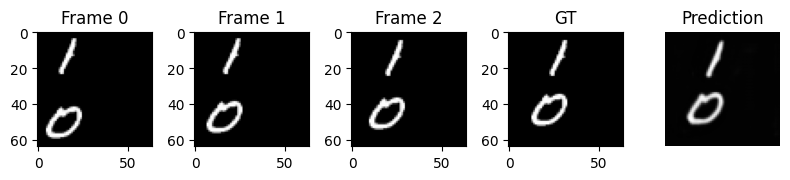

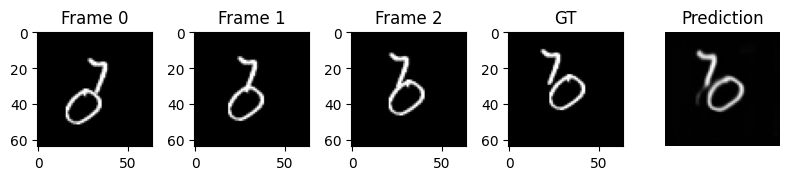

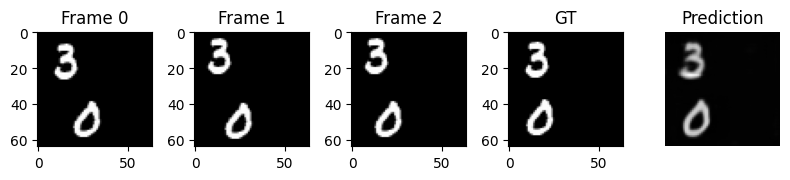

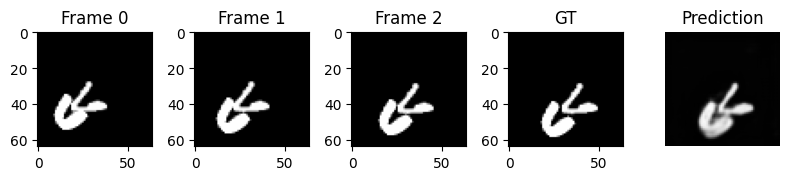

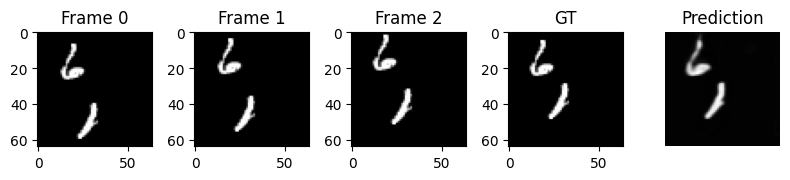

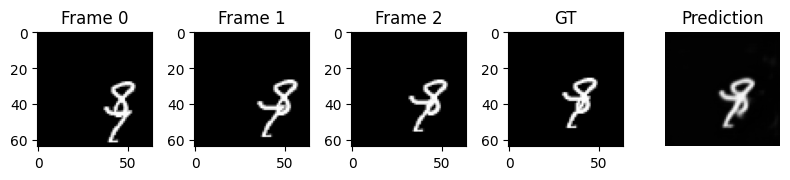

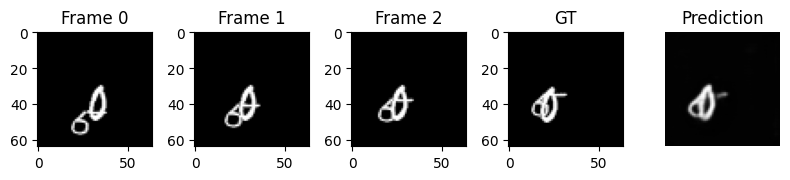

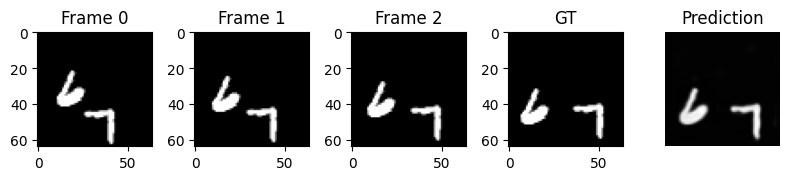

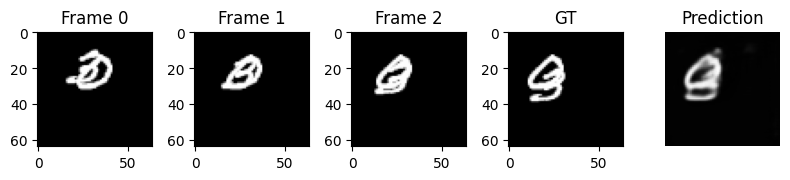

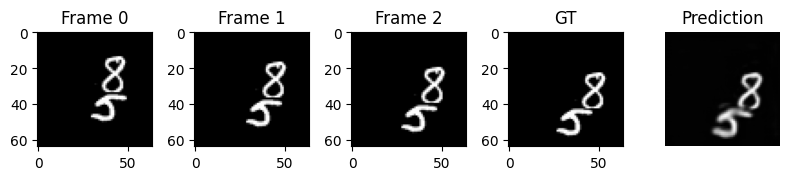

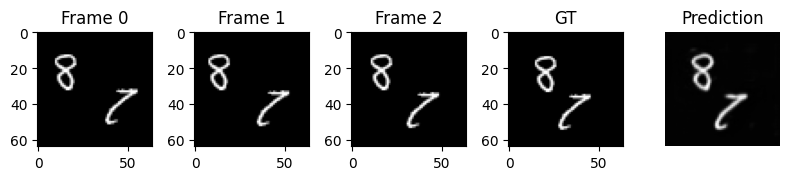

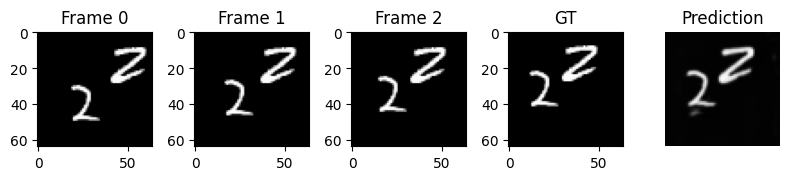

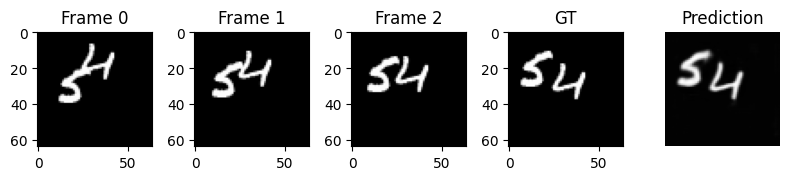

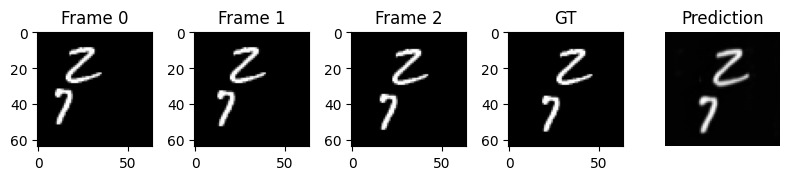

"\nfor el in range(16):\n    plt.figure(figsize=(6, 4))\n    plt.subplot(1, 2,1)\n    plt.title('Prediction')\n    plt.imshow(approximated_y[el,:,:,0],cmap='gray',)\n    plt.subplot(1, 2, 2)\n    plt.title('Ground Truth ')\n    plt.imshow(sample_y[el,:,:,0],cmap='gray',)\n    plt.show()\n"

In [ ]:
sample_x, sample_y = next(test_gen)
approximated_y = model.predict(sample_x)
for el in range(16):
  all = [sample_x[el,:,:,i] for i in range(3)]+[sample_y[el,:,:,0]]+[approximated_y[el,:,:,0]]
  show_list(all)

# Comparison with other models
During this week I focused mainly on CNN to explore how convolution can be enough to solve the task of next frame prediction

I also tried to implement SimVP with Inception module instead of gSTA but the training process was way slower (this model was trained using a T4 from colab as a gpu)

Lastly I tried CNN-LSTM and I got an MSE around 0,0105